# Pricing European Call Options

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from algorithms import ModifiedIterativeAmplitudeEstimation    # Import the modified version of the algorithm
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

## Uncertainty Model

In [4]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

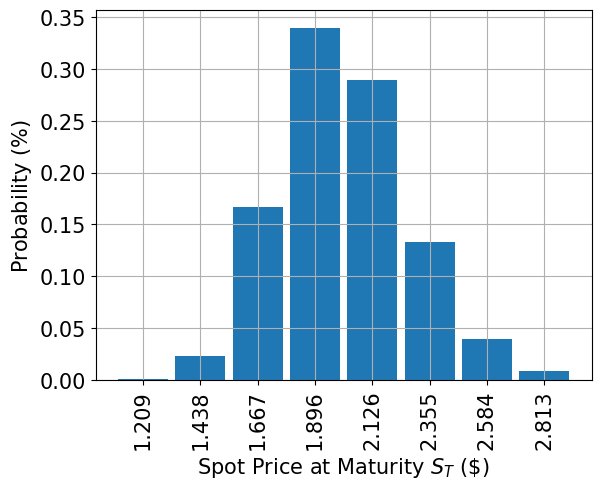

In [5]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

## Payoff Function

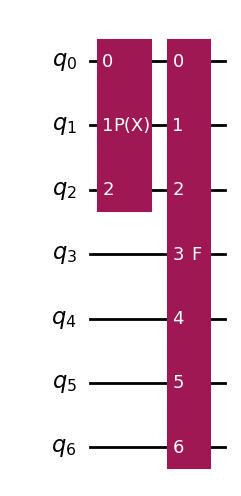

In [6]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw('mpl')



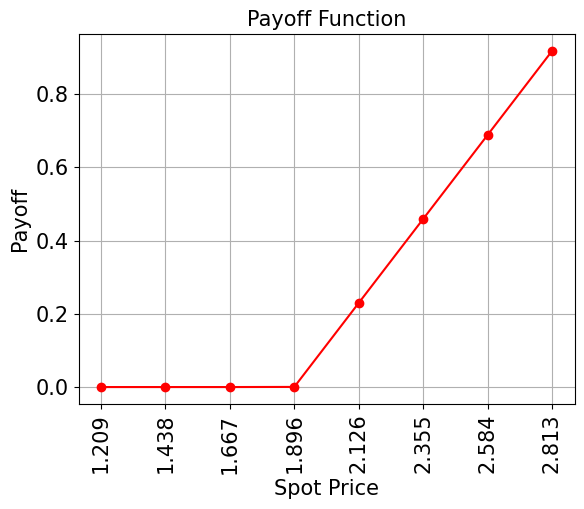

In [7]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [8]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)



exact expected value:	0.1623
exact delta value:   	0.8098


## Evaluate Expected Payoff

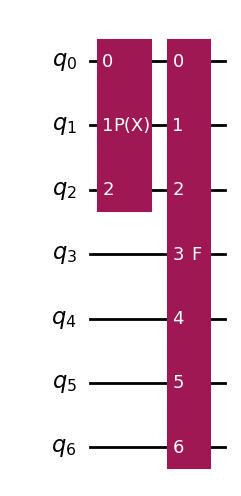

In [10]:
european_call.draw('mpl')

### Iterative Amplitude Estimation

In [11]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)

In [12]:
result = ae.estimate(problem)

In [13]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1687
Confidence interval:	[0.1637, 0.1737]


### Modified Iterative Amplitude Estimation

#### Beta

In [33]:
miqae = ModifiedIterativeAmplitudeEstimation(epsilon_target=0.01,
                                                  alpha=0.05,
                                                  confint_method='beta',
                                                  sampler=Sampler(run_options={"shots": 1000, "seed": 75}))

In [45]:
result = miqae.estimate(problem,shots=100)

In [46]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1687
Confidence interval:	[0.1646, 0.1728]


#### Chernoff

In [29]:
miqae = ModifiedIterativeAmplitudeEstimation(epsilon_target=0.01,
                                                  alpha=0.05,
                                                  confint_method='chernoff',
                                                  sampler=Sampler(run_options={"shots": 1000, "seed": 75}))

In [31]:
result = miqae.estimate(problem,shots=100)

In [32]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1691
Confidence interval:	[0.1594, 0.1789]


Instead of constructing these circuits manually, the Qiskit Finance module offers the EuropeanCallPricing circuit, which already implements this functionality as a building block.

In [47]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)



In [49]:
result = miqae.estimate(problem,shots=100)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1687
Confidence interval:	[0.1646, 0.1728]


## Evaluate Delta

In [50]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

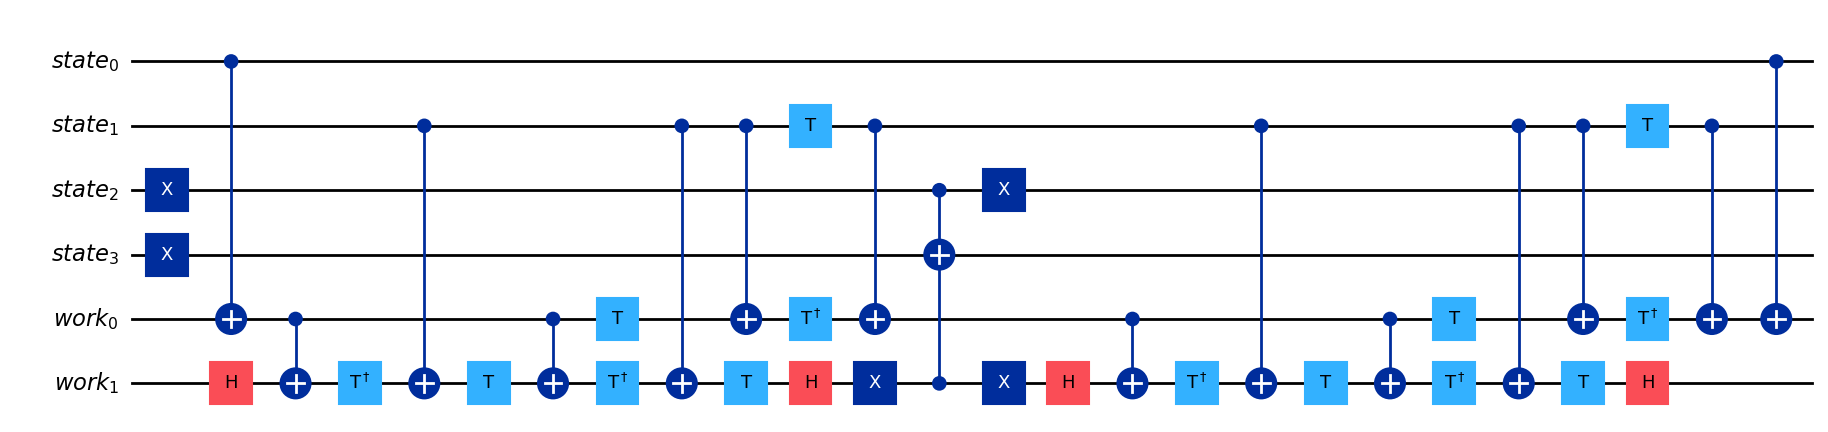

In [52]:
european_call_delta._objective.decompose(reps=3).draw('mpl',fold=-1)



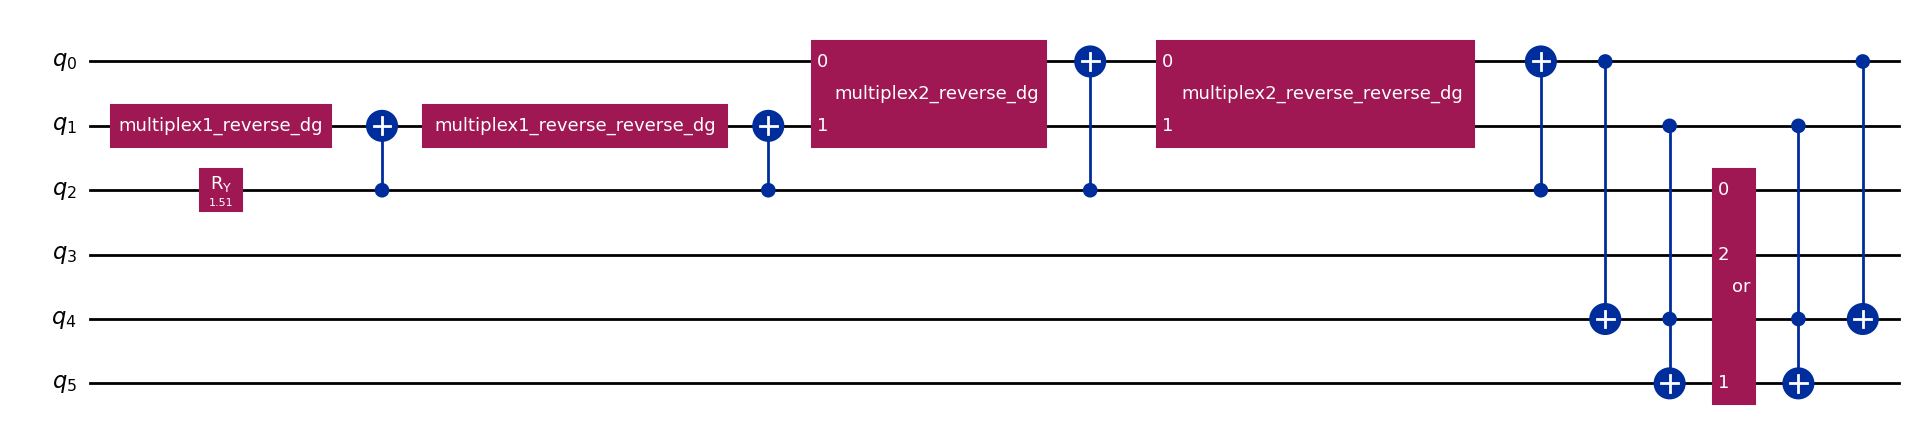

In [54]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.decompose(reps=3).draw('mpl',fold=-1)



In [56]:
problem = european_call_delta.to_estimation_problem()
result_delta = miqae.estimate(problem,shots=100)

In [57]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))



Exact delta:    	0.8098
Estimated value: 	0.8091
Confidence interval: 	[0.8035, 0.8148]


In [59]:
%pip list

Package                   Version
------------------------- --------------
anyio                     4.3.0
appdirs                   1.4.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cryptography              42.0.5
cycler                    0.12.1
data                      0.4
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
dill                      0.3.8
docplex                   2.27.239
exceptiongroup            1.2.0
executing                 2.0.1
fastdtw                   0.3.4
fastjsonschema   